## LIBRERÍAS Y CARGA DE DATOS

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from keras.layers import Dense, Dropout
import seaborn as sns
import glob
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import shutil
import random
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
# Despliega el cuadro de diálogo para subir archivos
uploaded = files.upload()

# Listar los archivos subidos (opcional)
for file_name in uploaded.keys():
    print(f'Archivo subido: {file_name}')

Saving kaggle.json to kaggle.json
Archivo subido: kaggle.json


In [3]:
# Crea la carpeta .kaggle y mueve el archivo kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Cambia los permisos para el archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Instala la Kaggle CLI
!pip install -q kaggle

# Descarga el dataset utilizando el identificador del nuevo dataset
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

# Descomprimir el archivo descargado
!unzip -q brian-tumor-dataset.zip -d /content/brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 77% 83.0M/107M [00:00<00:00, 293MB/s]
100% 107M/107M [00:00<00:00, 299MB/s] 


## NORMALIZACIÓN, DIVISIÓN DEL Y PREPROCESAMIENTO DEL CONJUNTO DE DATOS

In [21]:
# Directorio original de las imágenes
original_data_dir = '/content/brain_tumor_dataset/Brain Tumor Data Set/Brain Tumor Data Set'

# Nombres de las carpetas con las imágenes
folders = os.listdir(original_data_dir)

# Proporción de imágenes para los conjuntos de validación y prueba
val_split = 0.2
test_split = 0.1

# Crear el directorio para los datos divididos
split_data_dir = '/content/split_data'
os.makedirs(split_data_dir, exist_ok=True)

# Iterar sobre las carpetas y dividir las imágenes
for folder in folders:
    folder_path = os.path.join(original_data_dir, folder)
    images = os.listdir(folder_path)

    random.shuffle(images)
    split_index_val = int(len(images) * (1 - val_split - test_split))
    split_index_test = int(len(images) * (1 - test_split))
    train_images = images[:split_index_val]
    val_images = images[split_index_val:split_index_test]
    test_images = images[split_index_test:]

    train_dir = os.path.join(split_data_dir, 'train', folder)
    val_dir = os.path.join(split_data_dir, 'val', folder)
    test_dir = os.path.join(split_data_dir, 'test', folder)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for image in train_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(train_dir, image)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(val_dir, image)
        shutil.copy(src, dst)

    for image in test_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(test_dir, image)
        shutil.copy(src, dst)

print("División completa.")

División completa.


In [24]:

split_data_dir = '/content/split_data'


train_count = 0
val_count = 0
test_count = 0

for folder in ['train', 'val', 'test']:
    for subfolder in os.listdir(os.path.join(split_data_dir, folder)):
        folder_path = os.path.join(split_data_dir, folder, subfolder)
        num_images = len(os.listdir(folder_path))
        if folder == 'train':
            train_count += num_images
        elif folder == 'val':
            val_count += num_images
        else:
            test_count += num_images

print(f"El número total de imágenes en train es: {train_count}")
print(f"El número total de imágenes en val es: {val_count}")
print(f"El número total de imágenes en test es: {test_count}")

El número total de imágenes en train es: 4346
El número total de imágenes en val es: 1675
El número total de imágenes en test es: 461


In [25]:
# Configuración de TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() 
print("REPLICAS: ", strategy.num_replicas_in_sync)


REPLICAS:  1


In [26]:


split_data_dir = '/content/split_data'
train_dir = os.path.join(split_data_dir, 'train')
val_dir = os.path.join(split_data_dir, 'val')
test_dir = os.path.join(split_data_dir, 'test')


IMAGE_SIZE = [224, 224]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 12


In [27]:
# Generadores de datos con aumento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4346 images belonging to 2 classes.
Found 1675 images belonging to 2 classes.
Found 461 images belonging to 2 classes.


## **MODELO PREENTRENADO VGG16**

In [28]:
with strategy.scope():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    ]
)

Epoch 1/12
271/271 [==============================] - 83s 284ms/step - loss: 0.5912 - accuracy: 0.6831 - val_loss: 0.4267 - val_accuracy: 0.8197 - lr: 0.0010
Epoch 2/12
271/271 [==============================] - 71s 261ms/step - loss: 0.4603 - accuracy: 0.7843 - val_loss: 0.3489 - val_accuracy: 0.8425 - lr: 0.0010
Epoch 3/12
271/271 [==============================] - 80s 295ms/step - loss: 0.4087 - accuracy: 0.8134 - val_loss: 0.3096 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 4/12
271/271 [==============================] - 73s 269ms/step - loss: 0.3943 - accuracy: 0.8259 - val_loss: 0.2889 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 5/12
271/271 [==============================] - 73s 269ms/step - loss: 0.3680 - accuracy: 0.8305 - val_loss: 0.2782 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 6/12
271/271 [==============================] - 70s 257ms/step - loss: 0.3589 - accuracy: 0.8402 - val_loss: 0.2617 - val_accuracy: 0.8888 - lr: 0.0010
Epoch 7/12
271/271 [==============================] 

In [30]:
hist_=pd.DataFrame(history.history)
hist_


loss  accuracy  val_loss  val_accuracy     lr
0   0.591225  0.683141  0.426703      0.819712  0.001
1   0.460261  0.784296  0.348929      0.842548  0.001
2   0.408694  0.813395  0.309559      0.859976  0.001
3   0.394301  0.825866  0.288941      0.878005  0.001
4   0.367954  0.830485  0.278153      0.871995  0.001
5   0.358947  0.840185  0.261661      0.888822  0.001
6   0.349057  0.849885  0.261084      0.888221  0.001
7   0.329102  0.858430  0.299784      0.863582  0.001
8   0.331519  0.854734  0.248770      0.888221  0.001
9   0.315907  0.864203  0.237205      0.893630  0.001
10  0.309585  0.868822  0.223213      0.899639  0.001
11  0.308424  0.868360  0.239963      0.888221  0.001

In [31]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(val_generator)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

105/105 [==============================] - 11s 103ms/step - loss: 0.2387 - accuracy: 0.8890
Loss en los datos de prueba: 0.2387111783027649
Precisión en los datos de prueba: 0.8889552354812622


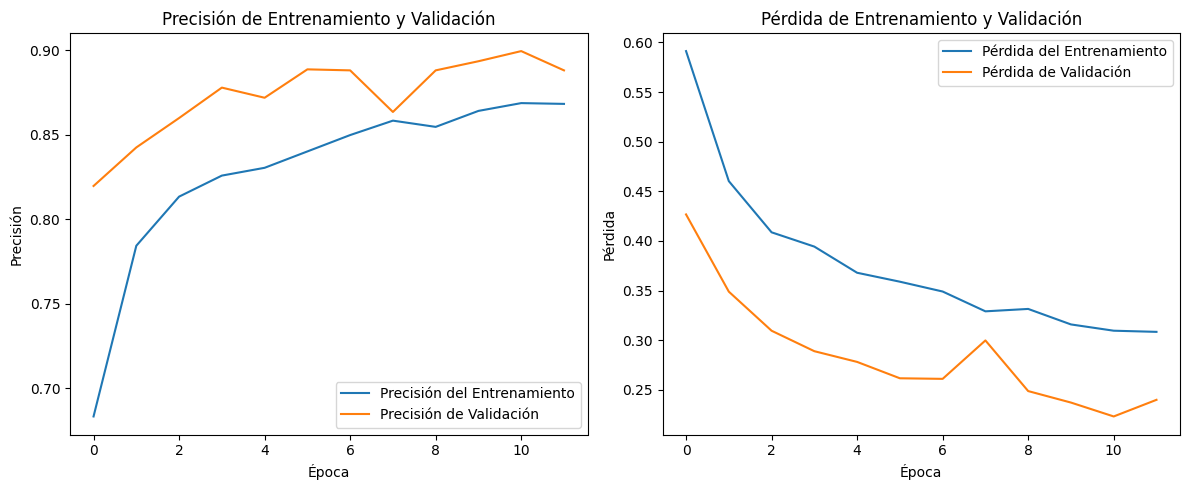

In [32]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Realizar predicciones en el conjunto de prueba
test_generator.reset()  # Asegúrate de reiniciar el generador antes de predecir
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Crear una tabla con los resultados
results = pd.DataFrame({
    'Filename': test_generator.filenames,
    'Clase Predicha': predicted_classes,
    'Clase Real': true_classes
})

# Agregar nombres de clases a la tabla
results['Nombre Clase Predicha'] = results['Clase Predicha'].apply(lambda x: class_labels[x])
results['Nombre Clase Real'] = results['Clase Real'].apply(lambda x: class_labels[x])

# Mostrar las primeras filas de la tabla
results.head()

29/29 [==============================] - 4s 130ms/step


Filename  Clase Predicha  Clase Real  \
0  Brain Tumor/Cancer (1027).JPG               1           0   
1  Brain Tumor/Cancer (1032).jpg               0           0   
2  Brain Tumor/Cancer (1056).jpg               0           0   
3  Brain Tumor/Cancer (1068).jpg               0           0   
4  Brain Tumor/Cancer (1073).JPG               0           0   

  Nombre Clase Predicha Nombre Clase Real  
0               Healthy       Brain Tumor  
1           Brain Tumor       Brain Tumor  
2           Brain Tumor       Brain Tumor  
3           Brain Tumor       Brain Tumor  
4           Brain Tumor       Brain Tumor

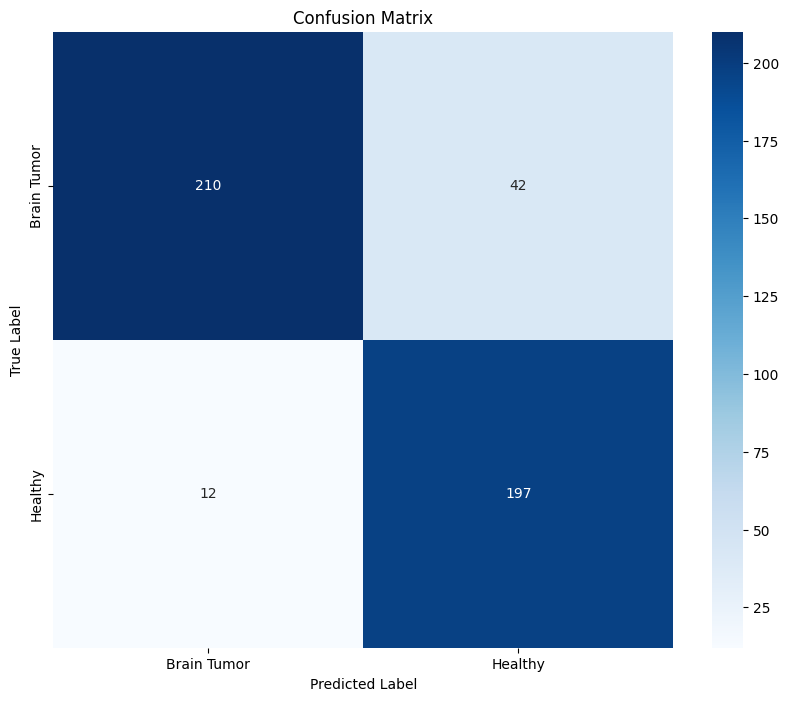

In [36]:
# Generar la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [37]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

 Brain Tumor       0.95      0.83      0.89       252
     Healthy       0.82      0.94      0.88       209

    accuracy                           0.88       461
   macro avg       0.89      0.89      0.88       461
weighted avg       0.89      0.88      0.88       461



In [42]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.resize(img, (224, 224))  
        img = img / 255.0  
        img = np.expand_dims(img, axis=-1)  
        img = np.expand_dims(img, axis=0)  
        return img
    else:
        return None

def predict_tumor_model1(image_path, model):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        return "Tumor" if prediction[0][0] > 0.5 else "Healthy"
    else:
        return "La imagen no se encontró o no pudo leerse"

def predict_tumor_with_prob_model1(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)

In [43]:
image_paths = [
    '/content/PRUEBA GL.png',
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA NO CANCER.png'
]

1/1 [==============================] - 0s 28ms/step


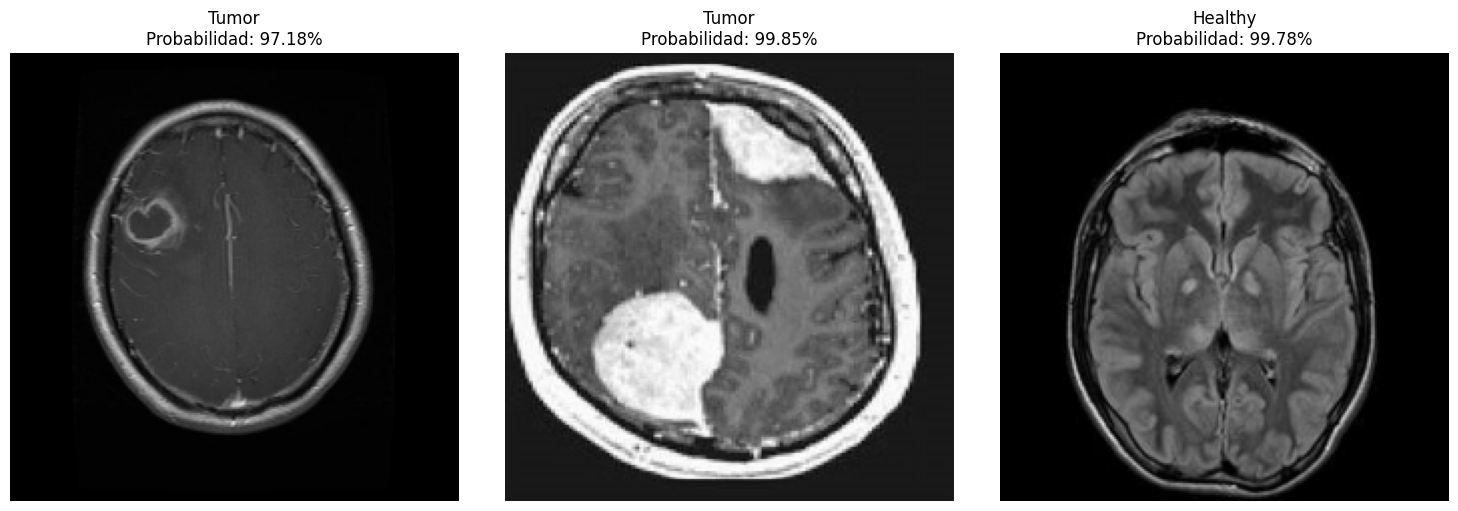

In [44]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model1(image_path, model)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}\nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((224, 224)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [47]:
def plot_roc_curve(model, test_generator):
    # Predecir probabilidades para el conjunto de prueba
    test_generator.reset()  
    y_pred_probs = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

    
    y_test = test_generator.classes

    
    if y_test.ndim == 2 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

  
    y_pred_probs = y_pred_probs[:len(y_test)]


    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])  # Asegurarse de usar la columna de la clase positiva

    roc_auc = auc(fpr, tpr)

    # Graficar la Curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Característica Operativa del Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()

29/29 [==============================] - 2s 67ms/step


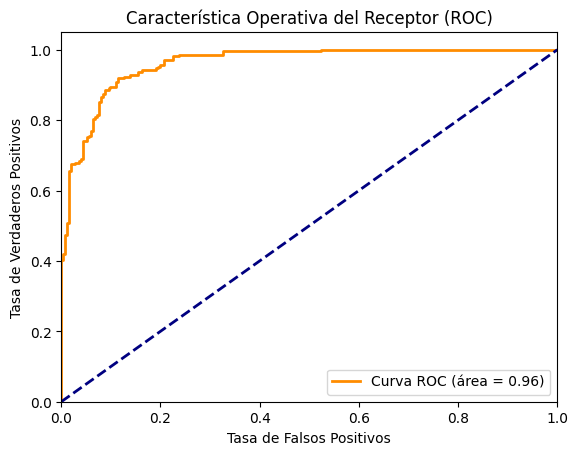

In [48]:
plot_roc_curve(model, test_generator)

In [49]:
print("Layers of Model vgg16:")
for layer in model.layers:
    print(layer.name)

Layers of Model vgg16:
input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d_1
dense_4
dropout_3
dense_5


In [62]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)  
    if img is None:
        raise FileNotFoundError(f"Error al cargar la imagen: {image_path}")
    img = cv2.resize(img, (224, 224)) 
    img = img / 255.0  
    img = np.expand_dims(img, axis=0) 
    return img

In [63]:
# Definir la función Grad-CAM
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

In [64]:
# Función para visualizar Grad-CAM
def display_gradcam(img, heatmap, alpha=0.6):
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img[0, :, :, 0][:, :, np.newaxis] * 255
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

In [65]:
# Cargar la imagen
image_path = '/content/EJ GL.jpg'  
img_array = load_and_preprocess_image(image_path)
image_path2 = '/content/PRUEBA GL.png'  
img_array2 = load_and_preprocess_image(image_path2)

In [66]:
images = [(img_array, 'EJ GL.jpg'), (img_array2, 'PRUEBA GL.png')]

In [67]:
layer_names_model1 = ['block5_conv1', 'block5_conv2', 'block5_conv3']  

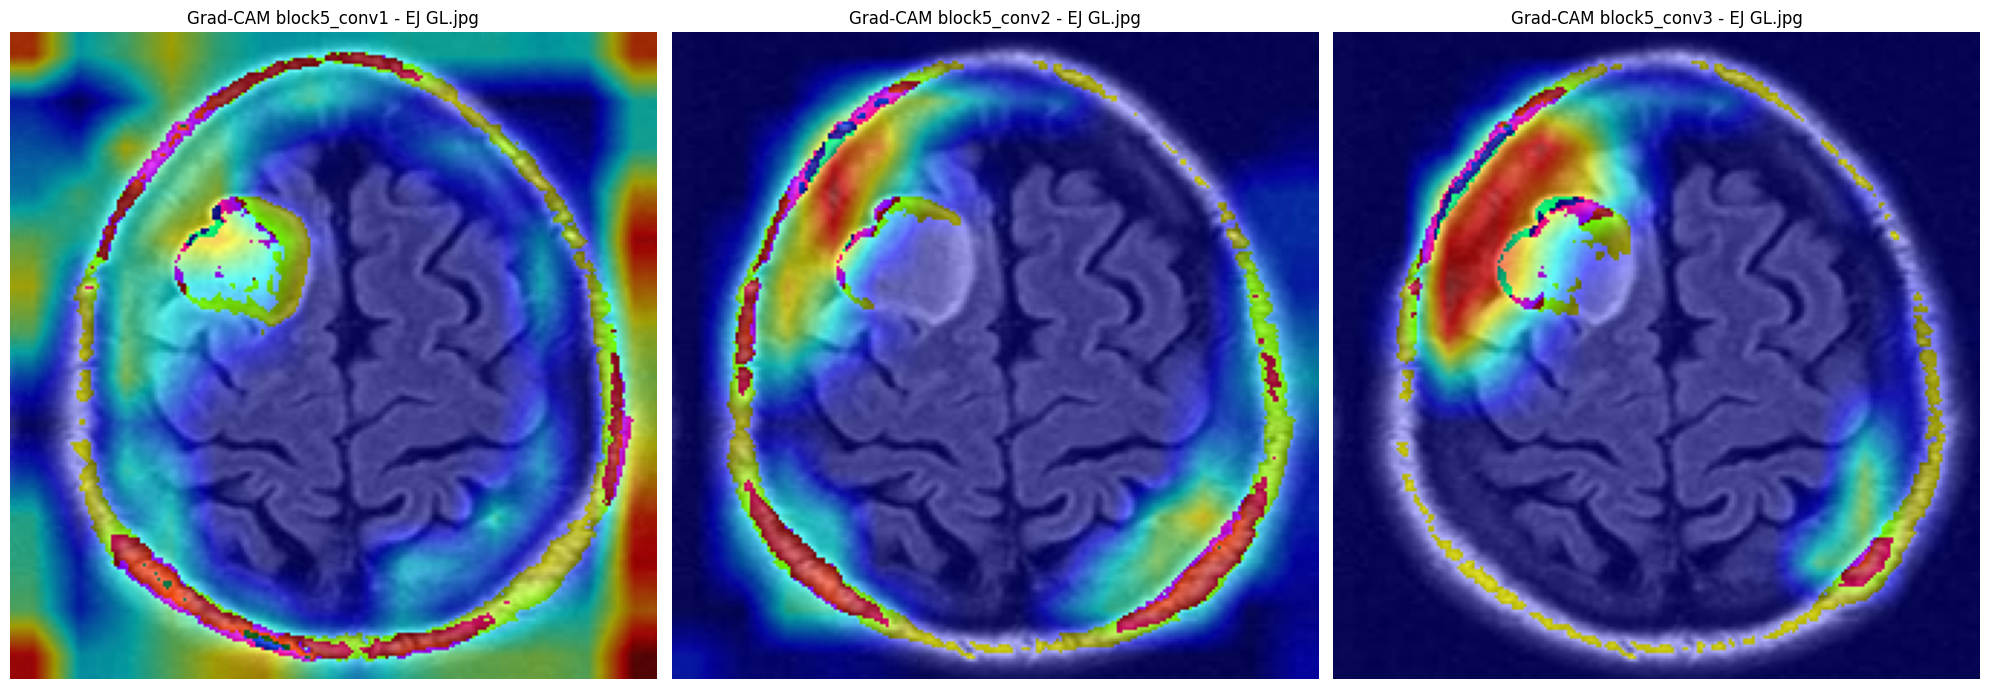

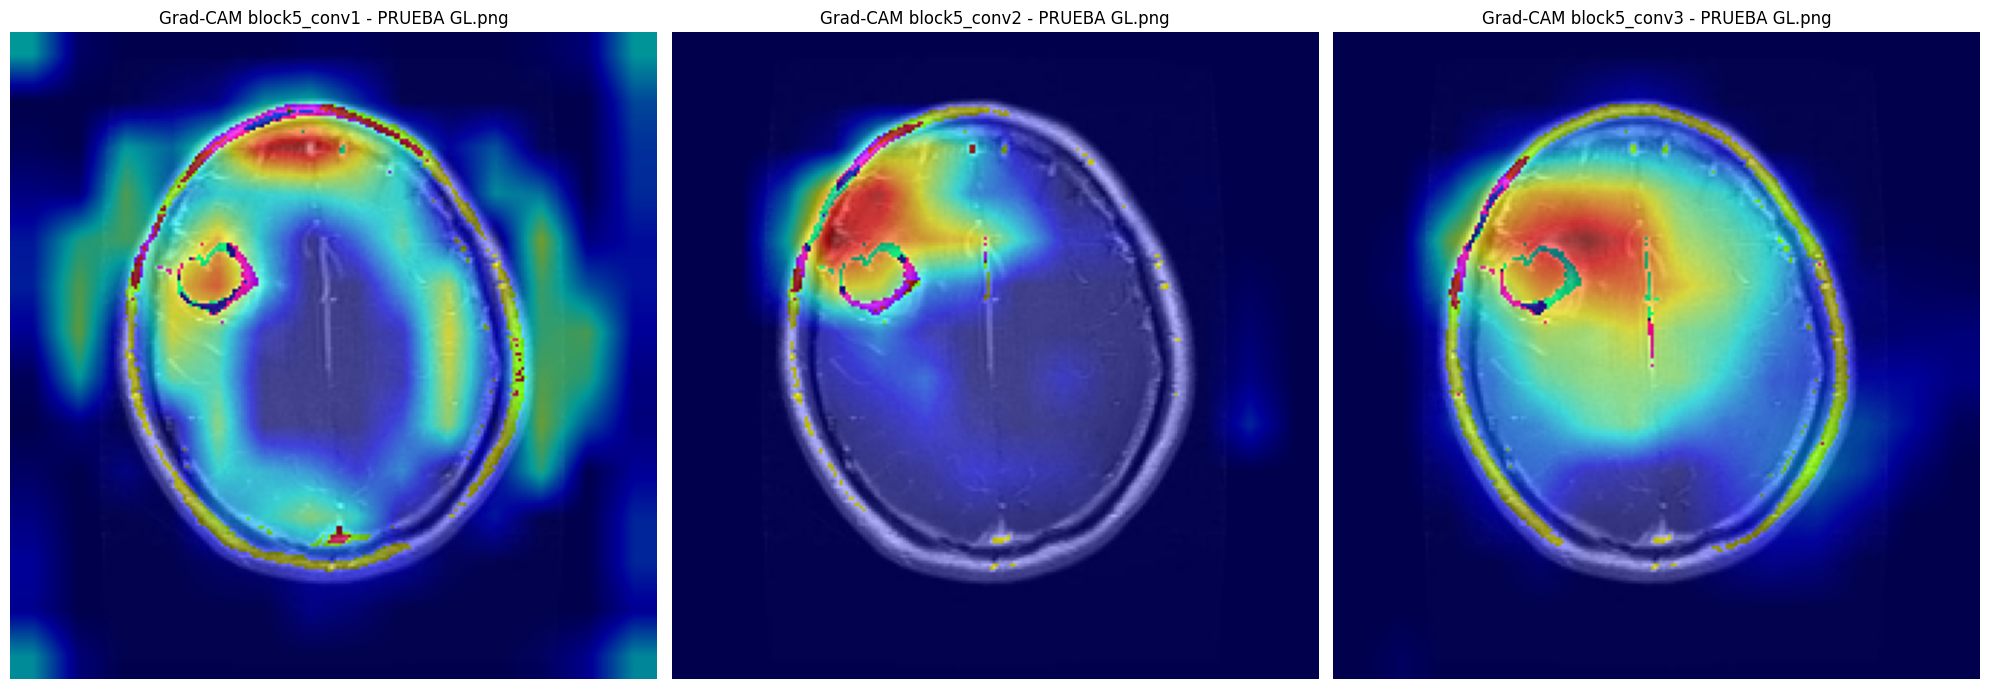

In [68]:
# Para Modelo 1
for img_array, img_name in images:
    plt.figure(figsize=(20, 10))
    for i, layer_name in enumerate(layer_names_model1):
        heatmap = get_gradcam(model, img_array, layer_name)
        superimposed_img = display_gradcam(img_array, heatmap)
        plt.subplot(1, len(layer_names_model1), i+1)
        plt.title(f'Grad-CAM {layer_name} - {img_name}')
        plt.imshow(superimposed_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [76]:
def analyze_errors(model, test_generator):
    # Reiniciar el generador de datos
    test_generator.reset()

    # Obtener las probabilidades de las predicciones
    y_pred_prob = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

    # Aplanar las predicciones y etiquetas verdaderas
    y_pred = y_pred_prob.argmax(axis=-1)
    y_test = test_generator.classes

    # Crear un DataFrame para comparar las etiquetas reales con las predichas
    results = pd.DataFrame({
        'Etiqueta Actual': y_test,
        'Etiqueta Predicha': y_pred
    })

    # Convertir etiquetas numéricas a categorías para mejor visualización
    results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Healthy', 1: 'Tumor'})
    results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Healthy', 1: 'Tumor'})

    # Identificar predicciones incorrectas
    incorrect_predictions = results[results['Etiqueta Actual'] != results['Etiqueta Predicha']]

    # Contar errores específicos
    count_tumor_predicted_as_healthy = len(incorrect_predictions[
        (incorrect_predictions['Etiqueta Actual'] == 'Tumor') &
        (incorrect_predictions['Etiqueta Predicha'] == 'Healthy')
    ])

    count_healthy_predicted_as_tumor = len(incorrect_predictions[
        (incorrect_predictions['Etiqueta Actual'] == 'Healthy') &
        (incorrect_predictions['Etiqueta Predicha'] == 'Tumor')
    ])

    # Mostrar resultados generales
    print("Número de predicciones incorrectas:", len(incorrect_predictions))
    print(incorrect_predictions)
    print("\n")

    # Mostrar errores específicos
    print("Errores específicos:")
    print("Tumor predicho como Healthy:", count_tumor_predicted_as_healthy)
    print("Healthy predicho como Tumor:", count_healthy_predicted_as_tumor)
    print("\n")

In [77]:
# Aplicar la función a cada modelo
print("Errores en Modelo VGG16:")
analyze_errors(model, test_generator)

Errores en Modelo VGG16:
29/29 [==============================] - 2s 67ms/step
Número de predicciones incorrectas: 54
    Etiqueta Actual Etiqueta Predicha
0           Healthy             Tumor
6           Healthy             Tumor
21          Healthy             Tumor
25          Healthy             Tumor
27          Healthy             Tumor
31          Healthy             Tumor
37          Healthy             Tumor
41          Healthy             Tumor
43          Healthy             Tumor
45          Healthy             Tumor
49          Healthy             Tumor
50          Healthy             Tumor
51          Healthy             Tumor
53          Healthy             Tumor
56          Healthy             Tumor
58          Healthy             Tumor
67          Healthy             Tumor
69          Healthy             Tumor
70          Healthy             Tumor
71          Healthy             Tumor
72          Healthy             Tumor
116         Healthy             Tumor
119     

In [78]:
# Descongelar las capas superiores del modelo
for layer in model.layers[-10:]:
    layer.trainable = True


In [79]:
# Compilar el modelo nuevamente
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [80]:
# Entrenar el modelo durante más épocas
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    ]
)

Epoch 1/10
271/271 [==============================] - 77s 263ms/step - loss: 0.4063 - accuracy: 0.8169 - val_loss: 0.1437 - val_accuracy: 0.9471 - lr: 1.0000e-04
Epoch 2/10
271/271 [==============================] - 73s 271ms/step - loss: 0.1454 - accuracy: 0.9476 - val_loss: 0.0464 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 3/10
271/271 [==============================] - 71s 262ms/step - loss: 0.1192 - accuracy: 0.9589 - val_loss: 0.0701 - val_accuracy: 0.9706 - lr: 1.0000e-04
Epoch 4/10
271/271 [==============================] - 72s 266ms/step - loss: 0.0828 - accuracy: 0.9714 - val_loss: 0.0210 - val_accuracy: 0.9940 - lr: 1.0000e-04
Epoch 5/10
271/271 [==============================] - 77s 286ms/step - loss: 0.0629 - accuracy: 0.9790 - val_loss: 0.0336 - val_accuracy: 0.9892 - lr: 1.0000e-04
Epoch 6/10
271/271 [==============================] - 76s 279ms/step - loss: 0.0634 - accuracy: 0.9783 - val_loss: 0.0214 - val_accuracy: 0.9934 - lr: 1.0000e-04
Epoch 7/10
271/271 [========

In [81]:
hist_=pd.DataFrame(history_fine.history)
hist_


loss  accuracy  val_loss  val_accuracy      lr
0  0.406306  0.816859  0.143715      0.947115  0.0001
1  0.145436  0.947575  0.046440      0.982572  0.0001
2  0.119242  0.958891  0.070068      0.970553  0.0001
3  0.082817  0.971363  0.020996      0.993990  0.0001
4  0.062894  0.978984  0.033630      0.989183  0.0001
5  0.063386  0.978291  0.021356      0.993389  0.0001
6  0.043880  0.986605  0.013740      0.997596  0.0001
7  0.047115  0.985219  0.009747      0.997596  0.0001
8  0.036146  0.987991  0.036321      0.986178  0.0001
9  0.048538  0.983372  0.013776      0.995793  0.0001

In [82]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(val_generator)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

105/105 [==============================] - 7s 67ms/step - loss: 0.0137 - accuracy: 0.9958
Loss en los datos de prueba: 0.01371268555521965
Precisión en los datos de prueba: 0.9958208799362183


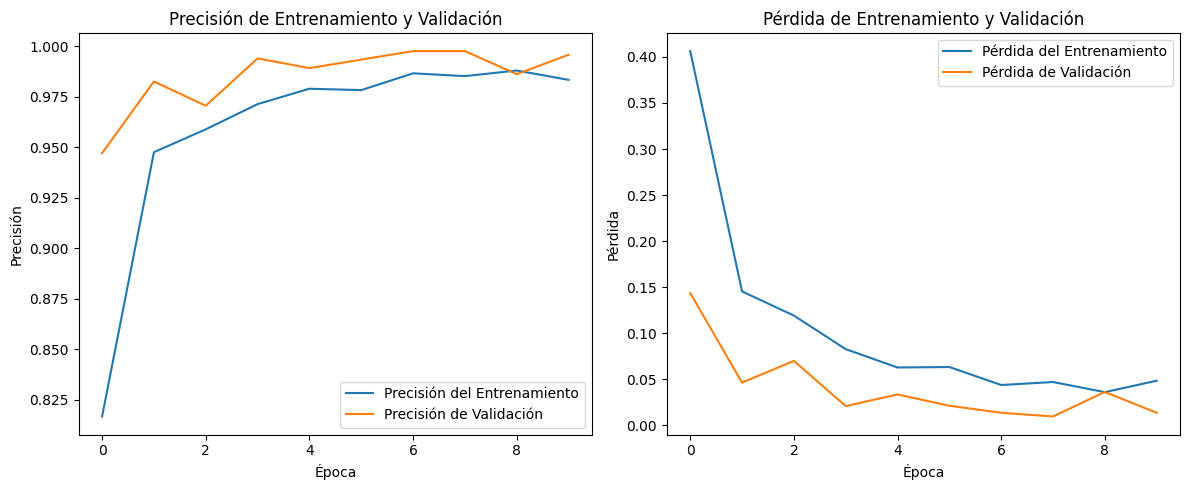

In [84]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history_fine.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history_fine.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
# Realizar predicciones en el conjunto de prueba
test_generator.reset()  # Asegúrate de reiniciar el generador antes de predecir
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Crear una tabla con los resultados
results = pd.DataFrame({
    'Filename': test_generator.filenames,
    'Clase Predicha': predicted_classes,
    'Clase Real': true_classes
})

# Agregar nombres de clases a la tabla
results['Nombre Clase Predicha'] = results['Clase Predicha'].apply(lambda x: class_labels[x])
results['Nombre Clase Real'] = results['Clase Real'].apply(lambda x: class_labels[x])

# Mostrar las primeras filas de la tabla
results.head()

29/29 [==============================] - 2s 70ms/step


Filename  Clase Predicha  Clase Real  \
0  Brain Tumor/Cancer (1027).JPG               0           0   
1  Brain Tumor/Cancer (1032).jpg               0           0   
2  Brain Tumor/Cancer (1056).jpg               0           0   
3  Brain Tumor/Cancer (1068).jpg               0           0   
4  Brain Tumor/Cancer (1073).JPG               0           0   

  Nombre Clase Predicha Nombre Clase Real  
0           Brain Tumor       Brain Tumor  
1           Brain Tumor       Brain Tumor  
2           Brain Tumor       Brain Tumor  
3           Brain Tumor       Brain Tumor  
4           Brain Tumor       Brain Tumor

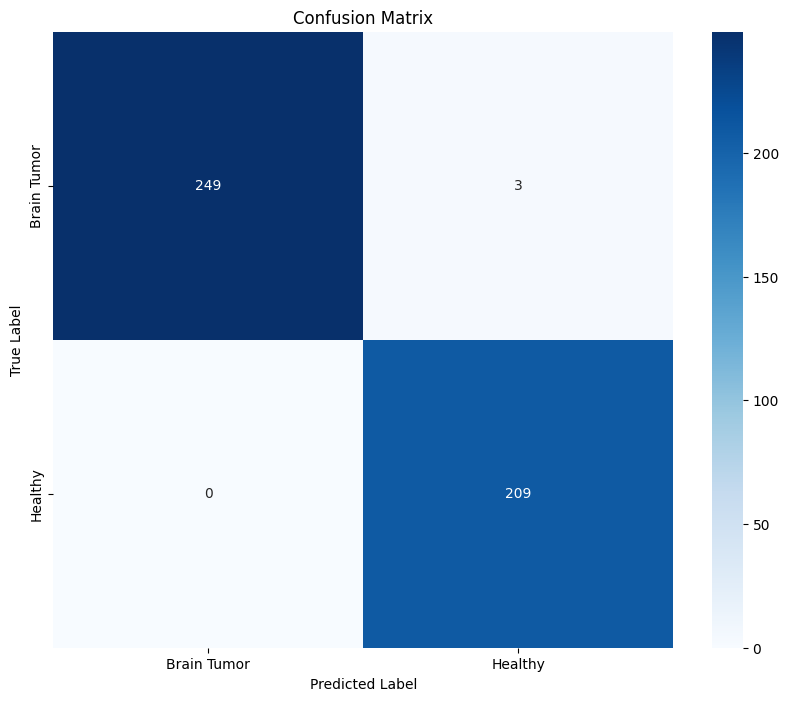

In [86]:
# Generar la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [87]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

 Brain Tumor       1.00      0.99      0.99       252
     Healthy       0.99      1.00      0.99       209

    accuracy                           0.99       461
   macro avg       0.99      0.99      0.99       461
weighted avg       0.99      0.99      0.99       461



In [88]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.resize(img, (224, 224))  
        img = img / 255.0  
        img = np.expand_dims(img, axis=-1)  
        img = np.expand_dims(img, axis=0)  
        return img
    else:
        return None

def predict_tumor_model1(image_path, model):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        return "Tumor" if prediction[0][0] > 0.5 else "Healthy"
    else:
        return "La imagen no se encontró o no pudo leerse"

def predict_tumor_with_prob_model1(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)

1/1 [==============================] - 0s 34ms/step


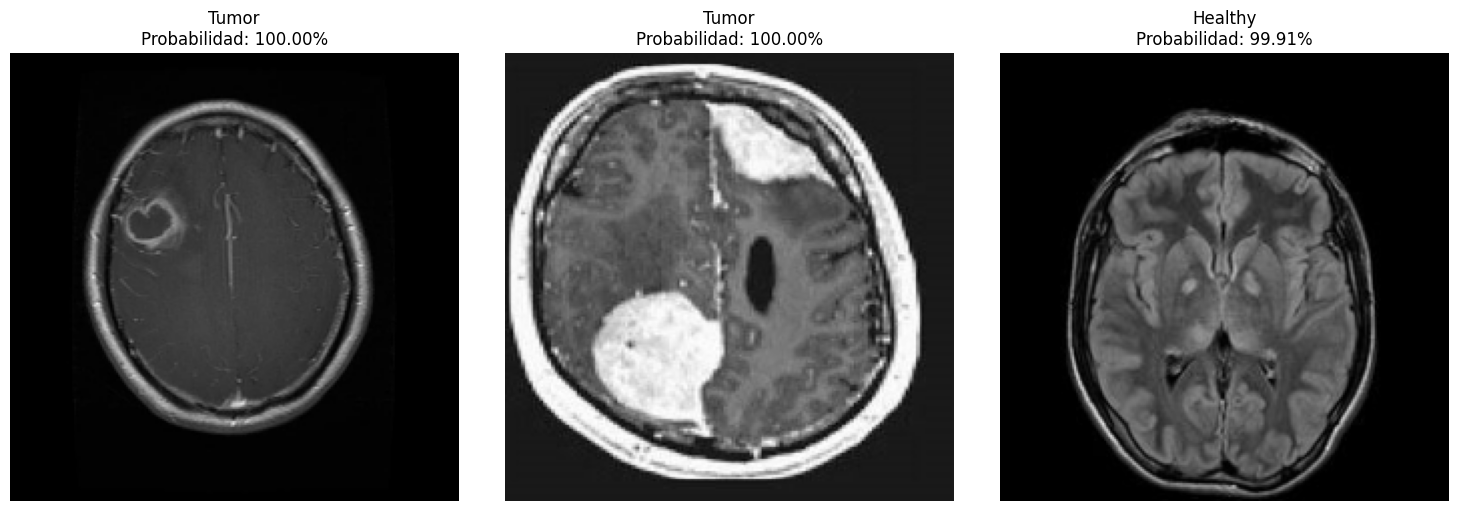

In [89]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model1(image_path, model)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}\nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((224, 224)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [90]:
def plot_roc_curve(model, test_generator):
    # Predecir probabilidades para el conjunto de prueba
    test_generator.reset()  
    y_pred_probs = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

    y_test = test_generator.classes

    if y_test.ndim == 2 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    y_pred_probs = y_pred_probs[:len(y_test)]

    # Calcular ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])  
    # Calcular AUC
    roc_auc = auc(fpr, tpr)

    # Graficar la Curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Característica Operativa del Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()

29/29 [==============================] - 2s 66ms/step


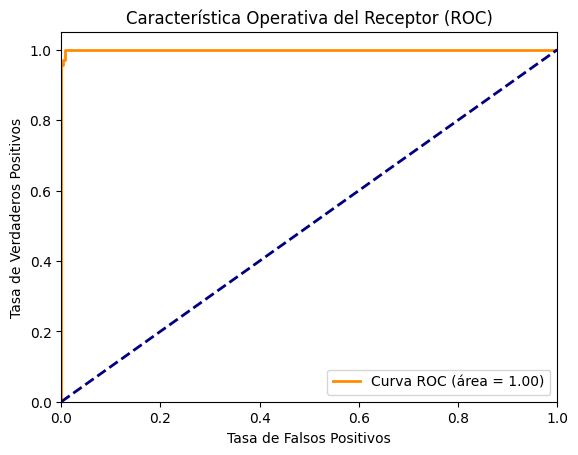

In [91]:
plot_roc_curve(model, test_generator)

In [92]:
print("Layers of Model Fine Tunning:")
for layer in model.layers:
    print(layer.name)

Layers of Model Fine Tunning:
input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d_1
dense_4
dropout_3
dense_5


In [93]:
layer_names_model2 = ['block5_conv1', 'block5_conv2', 'block5_conv3']  

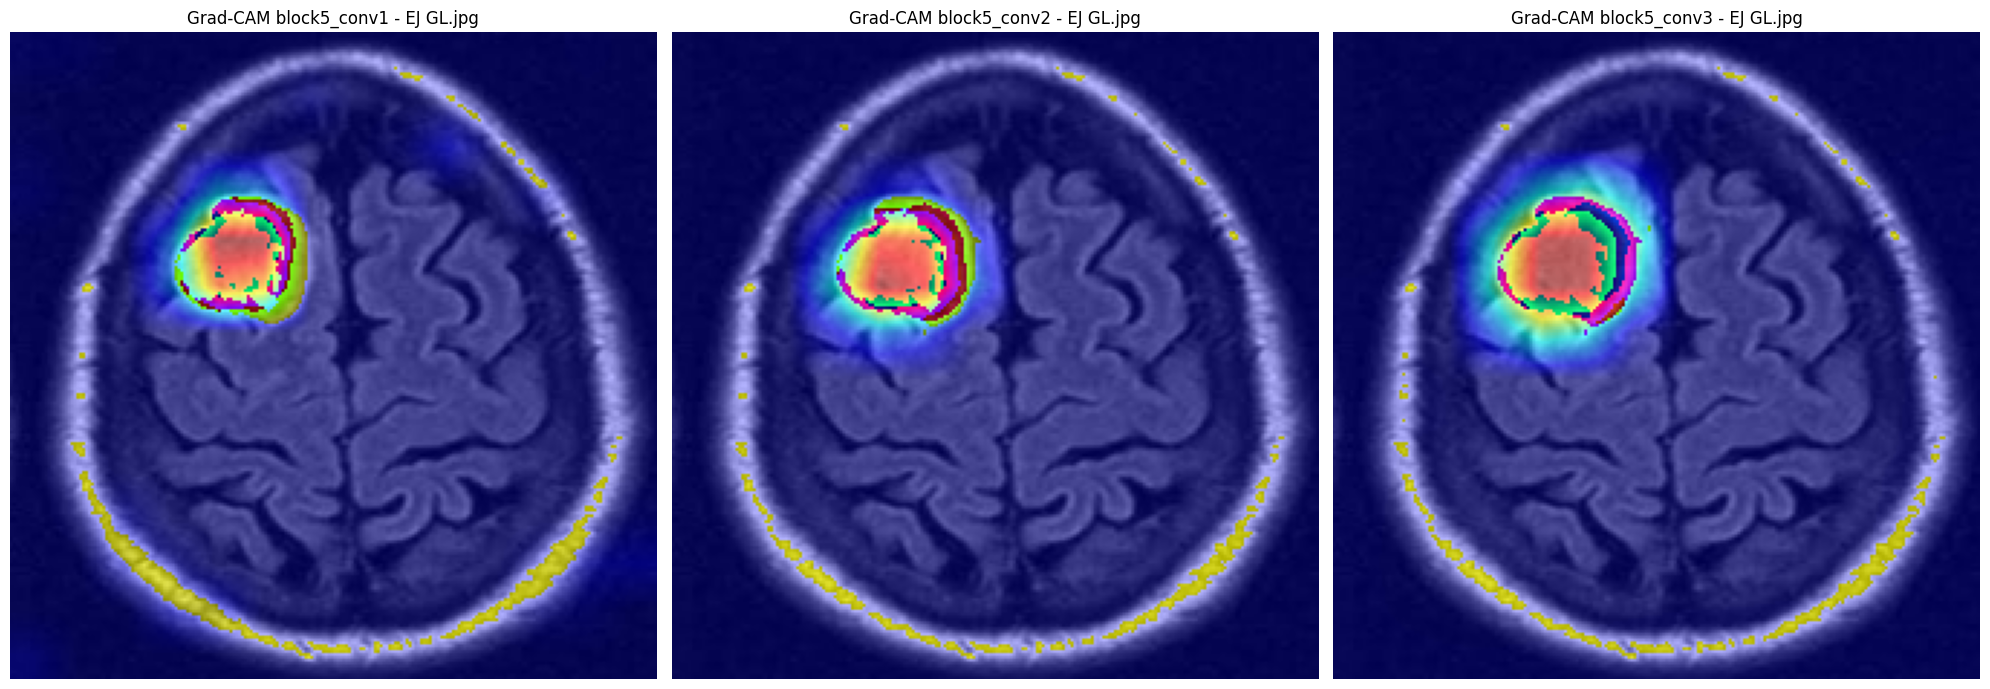

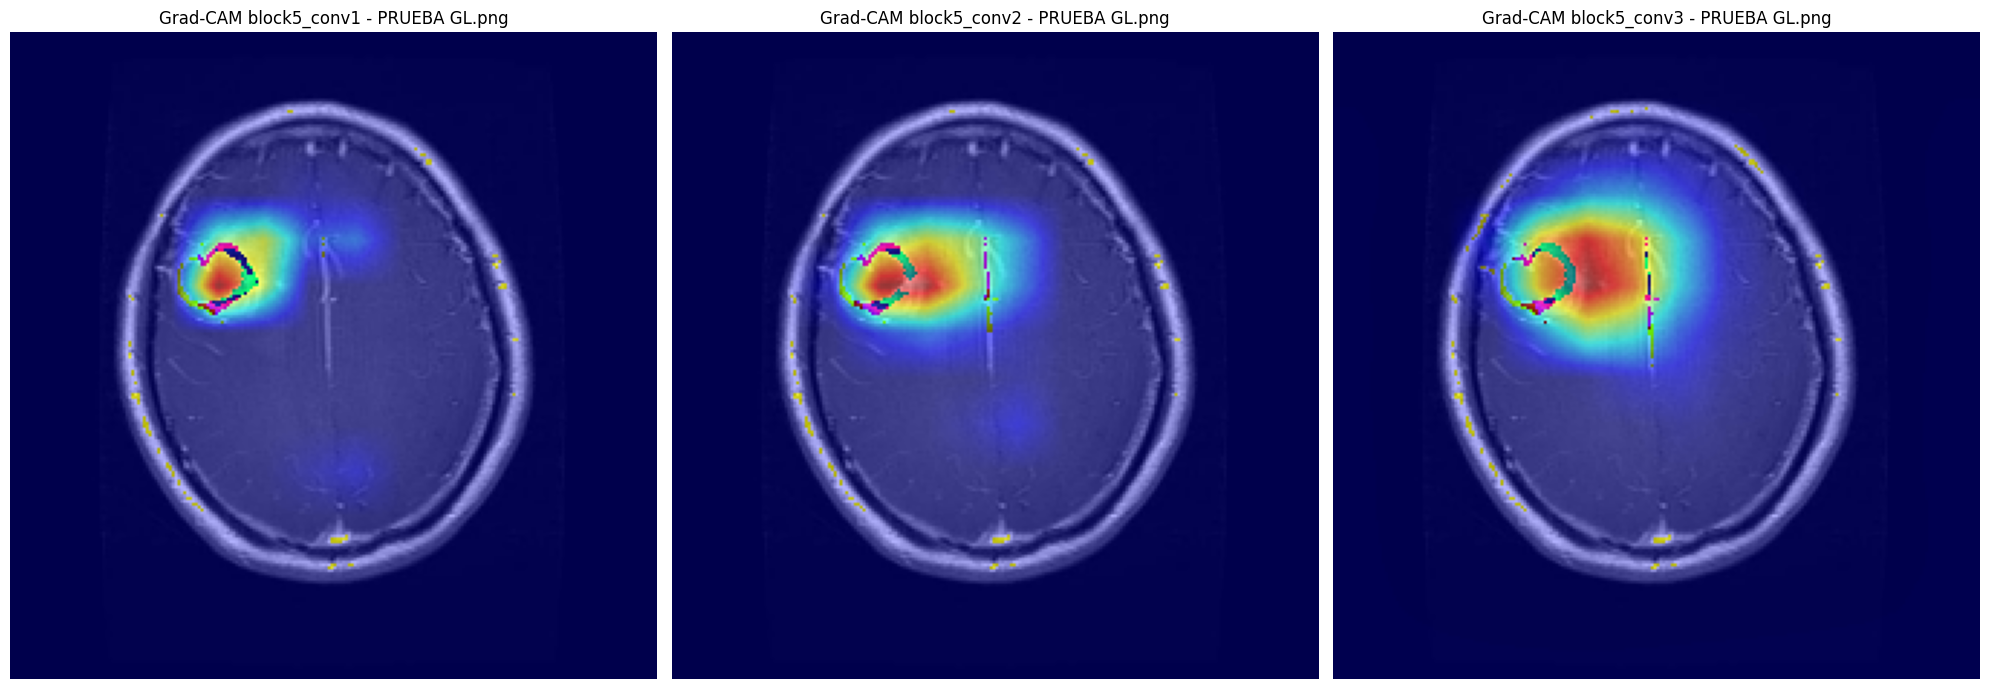

In [94]:
# Para Modelo 1
for img_array, img_name in images:
    plt.figure(figsize=(20, 10))
    for i, layer_name in enumerate(layer_names_model2):
        heatmap = get_gradcam(model, img_array, layer_name)
        superimposed_img = display_gradcam(img_array, heatmap)
        plt.subplot(1, len(layer_names_model2), i+1)
        plt.title(f'Grad-CAM {layer_name} - {img_name}')
        plt.imshow(superimposed_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [95]:
def analyze_errors(model, test_generator):
    # Reiniciar el generador de datos
    test_generator.reset()

    y_pred_prob = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

    y_pred = y_pred_prob.argmax(axis=-1)
    y_test = test_generator.classes

    results = pd.DataFrame({
        'Etiqueta Actual': y_test,
        'Etiqueta Predicha': y_pred
    })

    results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Healthy', 1: 'Tumor'})
    results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Healthy', 1: 'Tumor'})

    incorrect_predictions = results[results['Etiqueta Actual'] != results['Etiqueta Predicha']]

    count_tumor_predicted_as_healthy = len(incorrect_predictions[
        (incorrect_predictions['Etiqueta Actual'] == 'Tumor') &
        (incorrect_predictions['Etiqueta Predicha'] == 'Healthy')
    ])

    count_healthy_predicted_as_tumor = len(incorrect_predictions[
        (incorrect_predictions['Etiqueta Actual'] == 'Healthy') &
        (incorrect_predictions['Etiqueta Predicha'] == 'Tumor')
    ])

    # Mostrar resultados generales
    print("Número de predicciones incorrectas:", len(incorrect_predictions))
    print(incorrect_predictions)
    print("\n")

    # Mostrar errores específicos
    print("Errores específicos:")
    print("Tumor predicho como Healthy:", count_tumor_predicted_as_healthy)
    print("Healthy predicho como Tumor:", count_healthy_predicted_as_tumor)
    print("\n")

In [96]:
print("Errores en Modelo VGG16 Fine Tunning:")
analyze_errors(model, test_generator)

Errores en Modelo VGG16 Fine Tunning:
29/29 [==============================] - 2s 72ms/step
Número de predicciones incorrectas: 3
    Etiqueta Actual Etiqueta Predicha
201         Healthy             Tumor
205         Healthy             Tumor
239         Healthy             Tumor


Errores específicos:
Tumor predicho como Healthy: 0
Healthy predicho como Tumor: 3


